# 2-1. 프로젝트: 새로운 데이터셋으로 나만의 이미지 분류기 만들어보기


## Step 1. 데이터셋 내려받기

이번에는 tensorflow_datasets 에 포함된 tf_flowers 데이터를 사용해 보겠습니다.   
tf_flowers 데이터에 대한 정보는 다음에서 확인해볼 수 있습니다.  

tfds.load를 활용하여 데이터셋을 다운받으세요.

In [35]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [36]:
(raw_train, raw_validation, raw_test), metadata = tfds.load('tf_flowers',
                               split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                               with_info=True,
                               as_supervised=True)

## Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기
이미지를 모두 같은 크기로 formatting 한 후,  
train_batches, validation_batches, test_batches를 준비합니다.

In [46]:
IMG_SIZE = 160

def size_change(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label
    

 

In [47]:
train = raw_train.map(size_change)
validation = raw_validation.map(size_change)
test = raw_test.map(size_change)


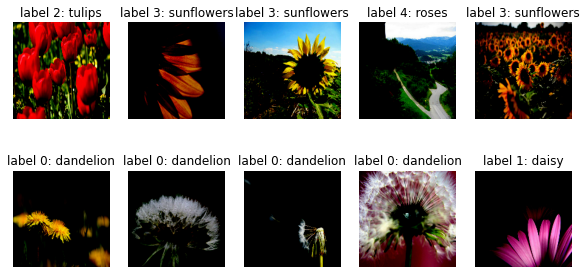

In [48]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    image = (image + 1) / 2
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [49]:

BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 2000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

## Step 3. 모델 설계하기
모델은 어떤 방식으로 설계하고 싶은가요? 나만의 모델을 만들 것인가요, 아니면 base_model을 활용할 것인가요?
원하는 방식으로 모델을 만들어 보세요!  

cats_vs_dogs 의 경우와 달리, tf_flowers 데이터셋에서는 class의 갯수가 5가지입니다.   
모델 설계시 어느 부분이 달라질지에 유의해 주세요.

In [50]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights='imagenet')

In [51]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

## Step 4. 모델 학습시키기
모델을 학습시켜봅니다. 단, 여기에서는 여러 가지 옵션을 바꿔볼 수 있습니다.
예를 들어, 모델 학습을 10 epoch보다 더 많이 시켜보거나, learning_rate 값을 바꿔볼 수 있습니다.

또는, optimizer의 종류도 바꿔볼 수 있습니다. 바꿔보고 싶다면, 여기를 참고하세요.
어쩌면 VGG16이 아닌 다른 모델을 base model로 활용할 수도 있을 것입니다. 그리고 파인튜닝을 fc layer의 구성에 변화를 줄 수 있을지도 모릅니다.
이전 스텝에서는 시도하지 않았던 Regularization 기법이 적용된다면 어떨까요? Dropout이나 Batch Normalization을 적용하는 것은 그리 어려운 일이 아닙니다.

In [44]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['accuracy'])
              
EPOCHES = 10
model.fit(train_batches,
          epochs = EPOCHES,
          validation_data = validation_batches)

Epoch 1/10
294/294 [==============================] - 12s 37ms/step - loss: 0.2405 - accuracy: 0.9230 - val_loss: 0.4414 - val_accuracy: 0.8501
Epoch 2/10
294/294 [==============================] - 11s 36ms/step - loss: 0.2376 - accuracy: 0.9223 - val_loss: 0.4397 - val_accuracy: 0.8447
Epoch 3/10
294/294 [==============================] - 12s 36ms/step - loss: 0.2335 - accuracy: 0.9210 - val_loss: 0.4428 - val_accuracy: 0.8420
Epoch 4/10
294/294 [==============================] - 12s 36ms/step - loss: 0.2284 - accuracy: 0.9257 - val_loss: 0.4612 - val_accuracy: 0.8365
Epoch 5/10
294/294 [==============================] - 12s 36ms/step - loss: 0.2255 - accuracy: 0.9292 - val_loss: 0.4431 - val_accuracy: 0.8474
Epoch 6/10
294/294 [==============================] - 12s 36ms/step - loss: 0.2227 - accuracy: 0.9298 - val_loss: 0.4587 - val_accuracy: 0.8392
Epoch 7/10
294/294 [==============================] - 12s 36ms/step - loss: 0.2170 - accuracy: 0.9305 - val_loss: 0.4535 - val_accuracy:

In [53]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(512, activation ='relu')
prediction_layer = tf.keras.layers.Dense(5, activation ='softmax')

In [54]:
base_model.trainable = False

In [55]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer,
    prediction_layer
])

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


## Step 5. 모델 성능 평가하기
모델 학습이 완료되었다면, 모델의 성능을 평가할 차례입니다.
모델이 학습된 과정을 그래프로도 그려보고,  
validation_batches나 test_batches에 있는 데이터에 대한 예측 결과도 확인해 보세요!

In [57]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [58]:
# 학습 전 모델
validation_steps = 30
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

30/30 [==============================] - 1s 33ms/step - loss: 1.7166 - accuracy: 0.2233
initial loss: 1.72
initial accuracy: 0.22


In [59]:
EPOCHES = 10
history = model.fit(train_batches,
                   epochs = EPOCHES,
                   validation_data = validation_batches)

Epoch 1/10
294/294 [==============================] - 12s 37ms/step - loss: 1.2024 - accuracy: 0.6035 - val_loss: 0.9122 - val_accuracy: 0.7193
Epoch 2/10
294/294 [==============================] - 12s 37ms/step - loss: 0.8241 - accuracy: 0.7411 - val_loss: 0.7344 - val_accuracy: 0.7711
Epoch 3/10
294/294 [==============================] - 12s 37ms/step - loss: 0.6843 - accuracy: 0.7841 - val_loss: 0.6338 - val_accuracy: 0.7766
Epoch 4/10
294/294 [==============================] - 12s 36ms/step - loss: 0.6069 - accuracy: 0.8062 - val_loss: 0.5924 - val_accuracy: 0.7902
Epoch 5/10
294/294 [==============================] - 11s 36ms/step - loss: 0.5622 - accuracy: 0.8134 - val_loss: 0.5621 - val_accuracy: 0.7956
Epoch 6/10
294/294 [==============================] - 12s 36ms/step - loss: 0.5304 - accuracy: 0.8239 - val_loss: 0.5432 - val_accuracy: 0.8093
Epoch 7/10
294/294 [==============================] - 12s 37ms/step - loss: 0.5011 - accuracy: 0.8379 - val_loss: 0.5416 - val_accuracy:

## Step 6. 모델 활용하기
모델이 꽤나 똑똑해졌다면, 이제 활용해볼 수 있습니다.
원하는 이미지를 자유롭게 모델에 입력해 보고, 어떤 예측 결과를 내는지 확인해 보세요!

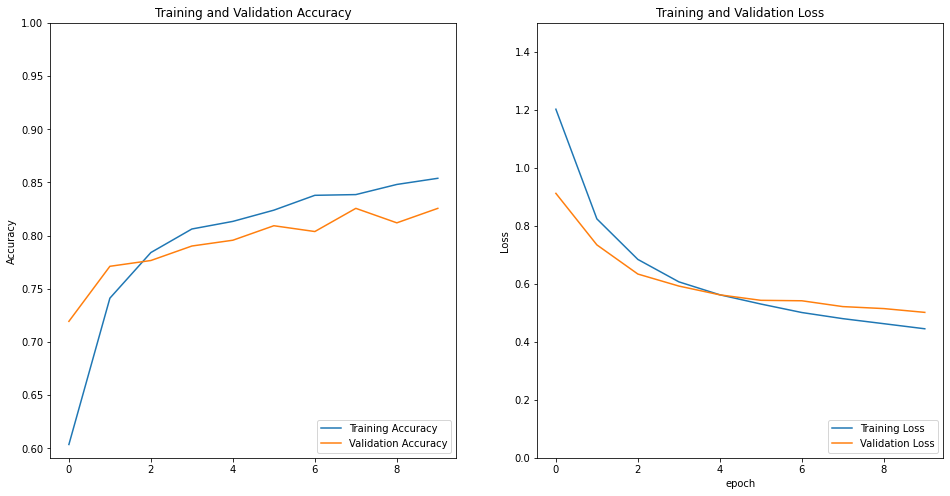

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.ylabel('Loss')
plt.ylim([0, 1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [61]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0])

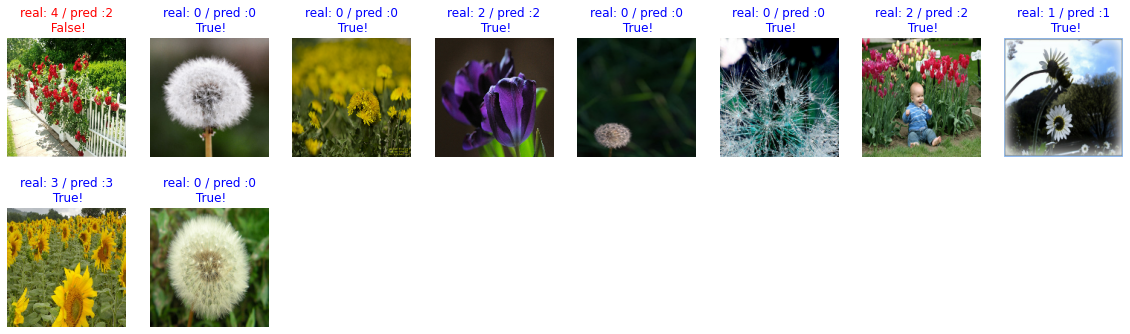

In [62]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    plt.axis('off')
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})